<a href="https://colab.research.google.com/github/mixa15341/Deep_Learning/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%967/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%967_%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%B0_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87_%D1%81%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №7. Использование автоэнкодера для решения задач семантической сегментации**

### Для выполнения задания необходимо скачать датасет по ссылке (снимки и маски, Version 1) . Обучить нейронную сеть предсказывать полноразмерную маску по загруженному снимку (см. теорию)

- ### Ссылка на датасет: https://landcover.ai.linuxpolska.com/#dataset



# Задание №1. Обучение готовой модели семантической сегментации для классификации спутниковых снимков

- Для работы с tiff-изображениями предлагается использовать библиотеку tifffile

In [18]:
!pip install split-folders
!pip install patchify
!pip install tifffile imagecodecs
!pip install tensorflow==2.9.0
!pip install -U -q segmentation-models

In [19]:
import os
import cv2
import numpy as np
import glob

from pathlib import Path
from imutils.paths import list_images

from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from keras.metrics import MeanIoU
import random

*Далее даны примеры кода, для их корректной работы пути необходимо сменить на Ваши*

### 1.1. Проверка вывода растра и масок

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


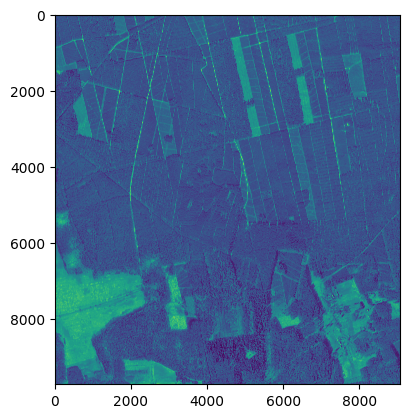

In [ ]:
temp_img = tiff.imread('/content/drive/MyDrive/landcover/images/M-33-7-A-d-2-3.tif')
plt.imshow(temp_img[:,:,0])

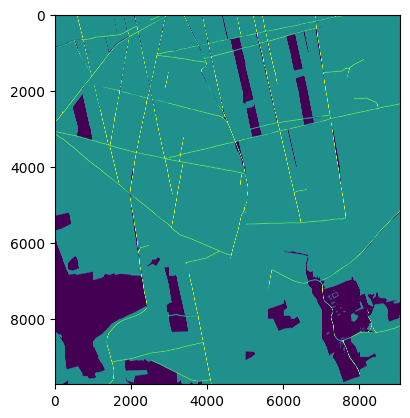

In [ ]:
temp_mask = tiff.imread('/content/drive/MyDrive/landcover/masks/M-33-7-A-d-2-3.tif')
plt.imshow(temp_mask)

In [ ]:
print(temp_img.shape)
print(temp_img.dtype)
print(temp_mask.shape)

labels, count = np.unique(temp_mask, return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

(9711, 9081, 3)
uint8
(9711, 9081)
Labels are:  [0 1 2 4]  and the counts are:  [10649007    60415 75869435  1606734]


In [21]:
root_directory = '/content/drive/MyDrive/landcover/'

patch_size = 256

### 1.2. Обрезка исходных растров на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [ ]:
#Считываем изображения из подкаталога 'images'.
#Поскольку все изображения имеют разный размер, у нас есть 2 варианта: изменить размер или обрезать.
#Но некоторые изображения слишком большие, а некоторые маленькие. Изменение размера изменит размер реальных объектов.
#Поэтому мы обрезаем их до ближайшего размера, кратного 256, а затем
#разделим все изображения на участки размером 256x256x3.
img_dir=root_directory+"images/"

# Создадим директорию для хранения батчей
Path(root_directory + '256_patches/images/').mkdir(parents=True, exist_ok=True)

for path, subdirs, files in os.walk(img_dir):
    print(path)
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    images = os.listdir(path)
    print(images)
    for i, image_name in enumerate(images):
        if image_name.endswith(".tif"):

            image = tiff.imread(path + "/" + image_name)

            SIZE_X = (image.shape[1] // patch_size) * patch_size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size

            image = image[0:SIZE_Y, 0:SIZE_X]

            print("Now patchifying image:", path + "/" + image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):

                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]

                    tiff.imwrite(root_directory+"256_patches/images/" + image_name +
                                 "patch_" + str(i) + str(j) + ".tif", single_patch_img, photometric='rgb')


/content/drive/MyDrive/landcover/images/

['M-33-20-D-d-3-3.tif', 'M-33-32-B-b-4-4.tif', 'M-33-7-A-d-3-2.tif', 'M-34-32-B-b-1-3.tif', 'M-34-5-D-d-4-2.tif', 'M-34-51-C-b-2-1.tif', 'M-34-55-B-b-4-1.tif', 'M-34-6-A-d-2-2.tif', 'M-34-65-D-c-4-2.tif', 'M-34-77-B-c-2-3.tif', 'N-33-130-A-d-3-3.tif', 'N-33-96-D-d-1-1.tif', 'N-34-106-A-c-1-3.tif', 'N-34-66-C-c-4-3.tif', 'M-33-7-A-d-2-3.tif', 'N-33-139-C-d-2-4.tif']
Now patchifying image: /content/drive/MyDrive/landcover/images//M-33-20-D-d-3-3.tif
Now patchifying image: /content/drive/MyDrive/landcover/images//M-33-32-B-b-4-4.tif
Now patchifying image: /content/drive/MyDrive/landcover/images//M-33-7-A-d-3-2.tif
Now patchifying image: /content/drive/MyDrive/landcover/images//M-34-32-B-b-1-3.tif
Now patchifying image: /content/drive/MyDrive/landcover/images//M-34-5-D-d-4-2.tif
Now patchifying image: /content/drive/MyDrive/landcover/images//M-34-51-C-b-2-1.tif
Now patchifying image: /content/drive/MyDrive/landcover/images//M-34-55-B-b-4-1.tif
Now 

### 1.3. Обрезка исходных масок на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [ ]:
mask_dir=root_directory + "masks/"

# Создадим директорию для хранения батчей
Path(root_directory + '256_patches/masks/').mkdir(parents=True, exist_ok=True)

for path, subdirs, files in os.walk(mask_dir):
    print(path)
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)
    for i, mask_name in enumerate(masks):
        if mask_name.endswith(".tif"):

            mask = cv2.imread(path + "/" + mask_name)

            SIZE_X = (mask.shape[1] // patch_size) * patch_size
            SIZE_Y = (mask.shape[0] // patch_size) * patch_size

            mask = mask[0:SIZE_Y, 0:SIZE_X]

            print("Now patchifying mask:", path + "/" + mask_name)
            patches_mask = patchify(mask, (256, 256, 1), step=256)

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):

                    single_patch_mask = patches_mask[i,j,:,:]
                    single_patch_mask = single_patch_mask[0]
                    tiff.imwrite(root_directory + "256_patches/masks/" +
                               mask_name + "patch_" + str(i) + str(j) + ".tif", single_patch_mask, photometric='minisblack')

/content/drive/MyDrive/landcover/masks/
Now patchifying mask: /content/drive/MyDrive/landcover/masks//M-34-77-B-c-2-3.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//N-33-139-C-d-2-4.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//M-34-55-B-b-4-1.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//N-33-96-D-d-1-1.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//M-33-7-A-d-2-3.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//N-33-130-A-d-3-3.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//M-34-5-D-d-4-2.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//M-33-7-A-d-3-2.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//M-34-51-C-b-2-1.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//N-34-66-C-c-4-3.tif
Now patchifying mask: /content/drive/MyDrive/landcover/masks//M-34-32-B-b-1-3.tif
Now patchifying mask: /content/drive/MyDrive/landcover/mask

### 1.4. Проверка патчей масок и исходного растра на соответствие

In [ ]:
img_dir = root_directory + '/256_patches/images/'
mask_dir = root_directory + '/256_patches/masks/'

img_list   = sorted(list_images(img_dir))
msk_list   = sorted(list_images(mask_dir))

img_count  = len(img_list)

print(f'Image patches count: {len(img_list)}')
print(f'Masks patches count: {len(msk_list)}')

Image patches count: 17302
Masks patches count: 17302


<Figure size 1200x800 with 0 Axes>

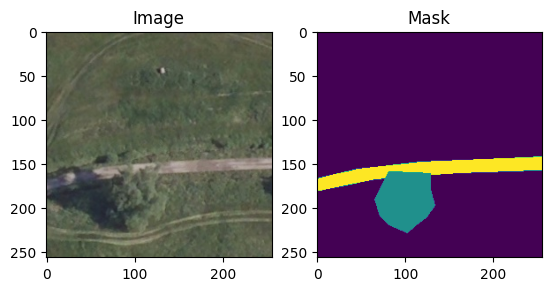

In [ ]:
import random
from matplotlib import pyplot as plt

img_num = random.randint(0, img_count - 1)

img_for_plot = tiff.imread(img_list[img_num])

mask_for_plot = tiff.imread(msk_list[img_num])

fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, vmin=0,vmax=10)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

### 1.5. Отсев неинформативных растров и соответствующих масок

Пропускаем изображения на которых один класс заднимает более 95% площади

In [ ]:
# Скопируем изображения и маски с реальной информацией в новую папку.

Path(root_directory + '256_patches/data/images/').mkdir(parents=True, exist_ok=True)
Path(root_directory + '256_patches/data/masks/').mkdir(parents=True, exist_ok=True)

useless=0
for i in tqdm(range(len(img_list))):
    img_name  = img_list[i].split('/')[-1]
    mask_name = msk_list[i].split('/')[-1]

    temp_image = tiff.imread(img_list[i])
    temp_mask  = tiff.imread(msk_list[i])

    #temp_mask=temp_mask.astype(np.uint8)

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.05:  # От 5% полезной площади
        tiff.imwrite(root_directory + '256_patches/data/images/' + img_name, temp_image, photometric='rgb')
        tiff.imwrite(root_directory + '256_patches/data/masks/' + mask_name, temp_mask, photometric='minisblack')

    else:
        useless += 1

print("Total useful images are: ", len(img_list) - useless)
print("Total useless images are: ", useless)

100%|██████████| 17302/17302 [3:01:58<00:00,  1.58it/s]

Total useful images are:  8347
Total useless images are:  8955


### 1.6. Формирование папок с обучающей и валидационной выборкой

In [ ]:
input_folder = root_directory + '256_patches/data/'
output_folder = root_directory + '256_patches/splitted_data/'
Path(output_folder).mkdir(parents=True, exist_ok=True)

In [ ]:
import splitfolders
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 0 files [00:00, ? files/s]

In [ ]:
import shutil

src_train_img = root_directory + '256_patches/splitted_data/train/images/'
src_train_msk = root_directory + '256_patches/splitted_data/train/masks/'
src_val_img   = root_directory + '256_patches/splitted_data/val/images/'
src_val_msk   = root_directory + '256_patches/splitted_data/val/masks/'

dst_train_img = root_directory + '256_patches/dataset/train_image/train/'
dst_train_msk = root_directory + '256_patches/dataset/train_mask/train/'
dst_val_img   = root_directory + '256_patches/dataset/val_image/val/'
dst_val_msk   = root_directory + '256_patches/dataset/val_mask/val/'

shutil.copytree(src_train_img, dst_train_img)
#shutil.copytree(src_train_msk, dst_train_msk)
#shutil.copytree(src_val_img, dst_val_img)
#shutil.copytree(src_val_msk, dst_val_msk)

'/content/drive/MyDrive/landcover/256_patches/dataset/train_image/train/'

Структура конечных папок для генератора (ImageDataGenerator()):

(После разделения на папки, нужно разместить вручную или написать для этого специальную функцию, например, используя модули os и/или shutil)



```
dataset
        train_image
                    train
        train_mask
                    train
        val_image
                    val
        val_mask
                    val
```



## Этап 2. Предобработка обучающей и валидационной выборки

### 2.1. Инициализация сформированной выборки

In [81]:
train_img_dir = root_directory + '256_patches/dataset2/train_image/'
train_msk_dir = root_directory + '256_patches/dataset2/train_mask/'
val_img_dir   = root_directory + '256_patches/dataset2/val_image/'
val_msk_dir   = root_directory + '256_patches/dataset2/val_mask/'

img_paths = sorted(list_images(train_img_dir))
msk_paths = sorted(list_images(train_msk_dir))

In [82]:
print(msk_paths)

['/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2525.tif', '/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2527.tif', '/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2528.tif', '/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2529.tif', '/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2530.tif', '/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2531.tif', '/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2533.tif', '/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2612.tif', '/content/drive/MyDrive/landcover/256_patches/dataset2/train_mask/train/N-34-106-A-c-1-3.tifpatch_2613.tif', '/content/drive/My

#### Проверка

<Figure size 1200x800 with 0 Axes>

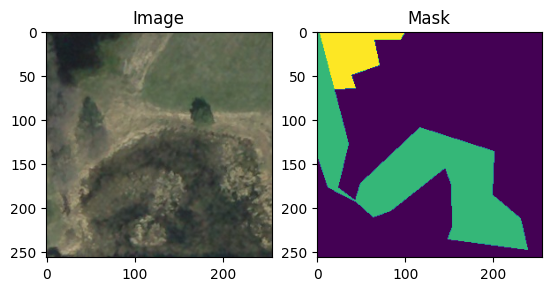

In [83]:
import random
img_count = len(os.listdir(train_img_dir))
img_num = random.randint(0, img_count - 1)

img_for_plot = cv2.cvtColor(
    cv2.imread(img_paths[img_num]),
    cv2.COLOR_BGR2RGB
)

mask_for_plot = tiff.imread(msk_paths[img_num])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, cmap=plt.get_cmap('gray'), vmin=0, vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

### 2.2. Предобработка обучающей выборки

Обратите внимание на формат масок в датасете. Возможно для решения этой задачи нет необходимости изменять исходные значения пикселей в маске.

In [84]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
scaler = MinMaxScaler()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Нормализация исходного патча и маски

In [85]:
def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)
    mask = mask[:,:,:,0]
    mask = to_categorical(mask, num_class)

    return (img, mask)

#### Проверка

In [ ]:
# Ваш код

### 2.3. Формирование последовательной загрузки набора данных с жесткого диска для обучения модели, используя Keras.ImageDataGenerator()

In [86]:
seed=24
batch_size=20
n_classes=5

In [87]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, target_generator)

    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target, num_class)
        yield (processed_img, processed_target)

In [88]:
train_img_gen = trainGenerator(train_img_dir, train_msk_dir, num_class=n_classes)
val_img_gen = trainGenerator(val_img_dir, val_msk_dir, num_class=n_classes)

train_steps_count = len(list(list_images(train_img_dir + '/' + 'train'))) // batch_size
val_steps_count = len(list(list_images(val_img_dir + '/' + 'val'))) // batch_size
print(f'Train steps per epoch: {train_steps_count}')
print(f'Val steps per epoch: {val_steps_count}')

Train steps per epoch: 7
Val steps per epoch: 5


#### Проверка:

Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Train image shape: (20, 256, 256, 3)
Train mask shape: (20, 256, 256, 5)
Val image shape: (20, 256, 256, 3)
Val mask shape: (20, 256, 256, 5)


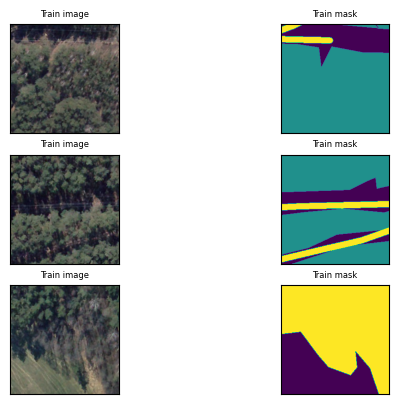

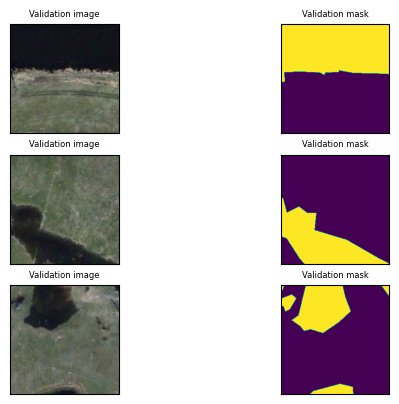

In [89]:
train_img_batch, train_mask_batch = next(train_img_gen)
train_mask_batch_argmax = np.argmax(train_mask_batch, axis=3)

val_img_batch, val_mask_batch = next(val_img_gen)
val_mask_batch_argmax = np.argmax(val_mask_batch, axis=3)

print(f'Train image shape: {train_img_batch.shape}')
print(f'Train mask shape: {train_mask_batch.shape}')
print(f'Val image shape: {val_img_batch.shape}')
print(f'Val mask shape: {val_mask_batch.shape}')

img_plot_count = 3

fig1, axis1 = plt.subplots(img_plot_count, 2)

for i in range(img_plot_count):
    axis1[i][0].imshow(train_img_batch[i])
    axis1[i][0].set_title('Train image', fontsize = 6)
    axis1[i][0].axes.xaxis.set_visible(False)
    axis1[i][0].axes.yaxis.set_visible(False)

    axis1[i][1].imshow(train_mask_batch_argmax[i])
    axis1[i][1].set_title('Train mask', fontsize = 6)
    axis1[i][1].axes.xaxis.set_visible(False)
    axis1[i][1].axes.yaxis.set_visible(False)

fig2, axis2 = plt.subplots(img_plot_count, 2)

for i in range(img_plot_count):
    axis2[i][0].imshow(val_img_batch[i])
    axis2[i][0].set_title('Validation image', fontsize = 6)
    axis2[i][0].axes.xaxis.set_visible(False)
    axis2[i][0].axes.yaxis.set_visible(False)

    axis2[i][1].imshow(val_mask_batch_argmax[i])
    axis2[i][1].set_title('Validation mask', fontsize = 6)
    axis2[i][1].axes.xaxis.set_visible(False)
    axis2[i][1].axes.yaxis.set_visible(False)

## Этап 3. Разработка архитектуры модели. Обучение модели

* Изучите техническую докуентацию по работе с модулем [Segmentation Models](https://segmentation-models.readthedocs.io/en/latest/tutorial.html)

* Последовательно обучите несколько моделей, используя при этом разные [функции потерь ](https://segmentation-models.readthedocs.io/en/latest/api.html#losses)

> [Реализация всех имеющихся в модуле функций потерь на GIT разработчиков](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/losses.py)

* При обучении используйте несколько метрик [метрик](https://segmentation-models.readthedocs.io/en/latest/api.html#metrics), определив их в массиве.



Пример:

```
metrics = ['accuracy', sm.metrics.iou_score]

model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
```
> [Реализация всех имеющихся в модуле метрик на GIT разработчиков](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/metrics.py)



In [69]:
from keras.optimizers import Adam
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [70]:
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

history2=model_resnet_backbone.fit(
          train_img_gen,
          steps_per_epoch=train_steps_count,
          epochs=10,
          verbose=1,
          validation_data=val_img_gen)

Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 1.2718 - accuracy: 0.5550 - iou_score: 0.1408 - f1-score: 0.2253 

KeyboardInterrupt: 

In [37]:
model_resnet_backbone.save('model_resnet_backbone.h5', save_format='h5')

## Этап 4. Визуализация процесса обучения. Оценка точности

In [ ]:
history = history2
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.1. Визуализация процесса обучения

### 4.2. Оценка оценка точности по валидационной выборке

In [57]:
from keras.models import load_model

# Загрузка обученной модели семантической сегментации
model = model_resnet_backbone

# Получение тестового изображения и соответствующей ему маски
test_image_batch, test_mask_batch = train_img_gen.__next__()

# Преобразование маски из категориального формата в формат меток классов
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)

# Выполнение предсказания на тестовом изображении
test_pred_batch = model.predict(test_image_batch)

# Преобразование предсказания из вероятностного формата в формат меток классов
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

# Количество классов
n_classes = 5

# Инициализация объекта для вычисления среднего IoU
IOU_keras = MeanIoU(num_classes=n_classes)

# Обновление состояния объекта среднего IoU на основе предсказания и истинной маски
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)

# Вывод среднего IoU
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 64s 64s/step
Mean IoU = 0.03494737


### 4.3. Визуализация предсказаний и сравнение их с оригинальными масками

<Figure size 1200x800 with 0 Axes>

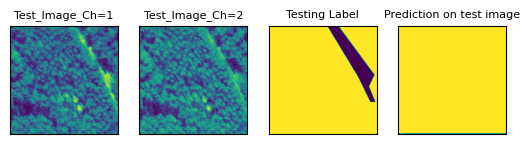

<Figure size 1200x800 with 0 Axes>

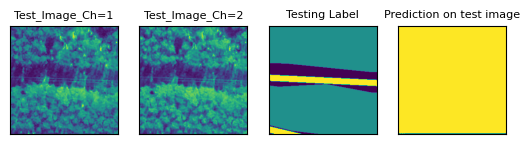

<Figure size 1200x800 with 0 Axes>

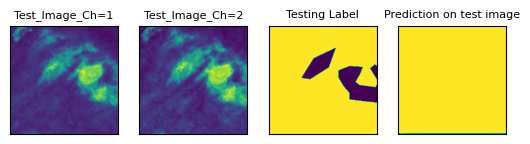

<Figure size 1200x800 with 0 Axes>

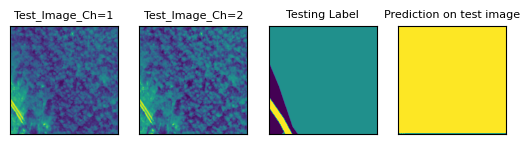

<Figure size 1200x800 with 0 Axes>

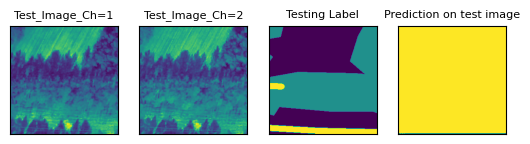

<Figure size 1200x800 with 0 Axes>

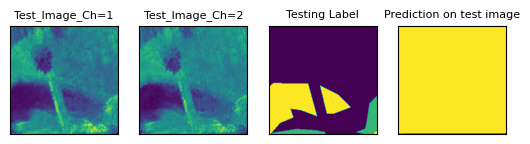

<Figure size 1200x800 with 0 Axes>

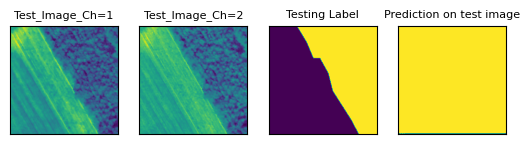

<Figure size 1200x800 with 0 Axes>

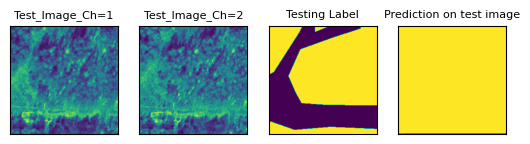

<Figure size 1200x800 with 0 Axes>

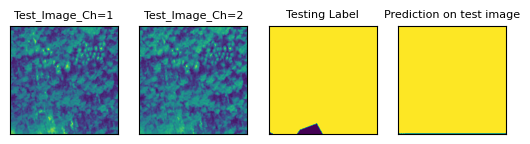

<Figure size 1200x800 with 0 Axes>

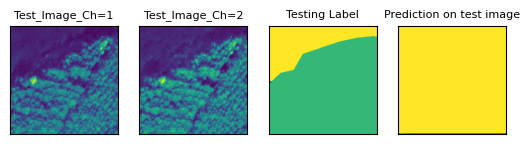

<Figure size 1200x800 with 0 Axes>

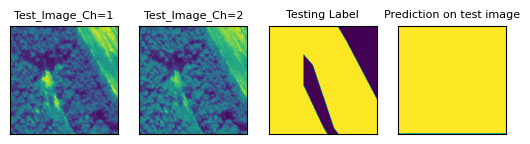

<Figure size 1200x800 with 0 Axes>

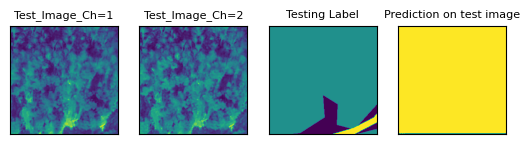

<Figure size 1200x800 with 0 Axes>

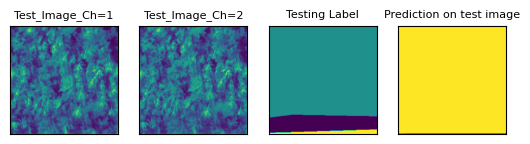

<Figure size 1200x800 with 0 Axes>

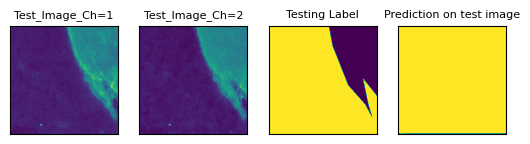

<Figure size 1200x800 with 0 Axes>

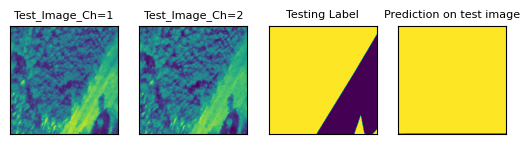

<Figure size 1200x800 with 0 Axes>

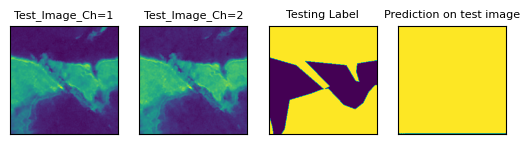

<Figure size 1200x800 with 0 Axes>

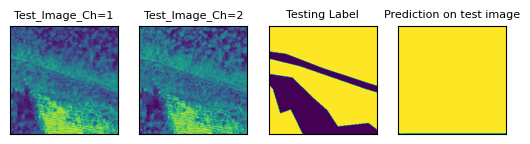

<Figure size 1200x800 with 0 Axes>

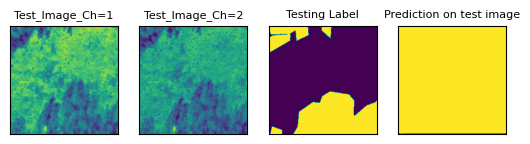

<Figure size 1200x800 with 0 Axes>

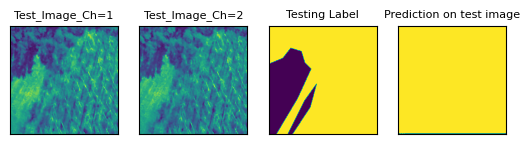

In [58]:
for img_num in range(test_image_batch.shape[0]-1):

    fig=plt.figure(figsize=(12,8), facecolor='w', edgecolor='k')

    figure, axis = plt.subplots(1, 4)
    fig.tight_layout()

    axis[0].imshow(test_image_batch[img_num][:,:,0])
    axis[0].set_title('Test_Image_Ch=1', fontsize = 8)
    axis[0].axes.xaxis.set_visible(False)
    axis[0].axes.yaxis.set_visible(False)

    axis[1].imshow(test_image_batch[img_num][:,:,1])
    axis[1].set_title('Test_Image_Ch=2', fontsize = 8)
    axis[1].axes.xaxis.set_visible(False)
    axis[1].axes.yaxis.set_visible(False)

    axis[2].imshow(test_mask_batch_argmax[img_num])
    axis[2].set_title("Testing Label", fontsize = 8)
    axis[2].axes.xaxis.set_visible(False)
    axis[2].axes.yaxis.set_visible(False)

    axis[3].imshow(test_pred_batch_argmax[img_num])
    axis[3].set_title("Prediction on test image", fontsize = 8)
    axis[3].axes.xaxis.set_visible(False)
    axis[3].axes.yaxis.set_visible(False)

    plt.show()

# Задание №2. Создание и обучение модели семантической сегментации для классификации спутниковых снимков

## Пример создания модели с Unet-подобной архитектурой

In [ ]:
from keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, Cropping2D, Softmax, Conv2DTranspose
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

In [ ]:
def mini_u_net(image_shape, num_of_classes):

  input_image = Input(image_shape)

  # Encoder

  conv1_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_1')(input_image)
  conv1_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_2')(conv1_1)

  pool_1 = MaxPooling2D(name = 'pool_1')(conv1_2)

  conv2_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_1')(pool_1)
  conv2_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_2')(conv2_1)

  pool_2 = MaxPooling2D(name = 'pool_2')(conv2_2)

  conv3_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_1')(pool_2)
  conv3_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_2')(conv3_1)

  pool_3 = MaxPooling2D(name = 'pool_3')(conv3_2)

  conv4_1 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_1')(pool_3)
  conv4_2 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_2')(conv4_1)



  # Decoder

  upconv5_1 = UpSampling2D(name = 'upconv5_1')(conv4_2)
  upconv5_2 = Conv2D(filters = 128, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv5_2')(upconv5_1)
  concat_5 = concatenate([upconv5_2, conv3_2], axis = 3, name = 'concat_5') # Split Connections

  conv5_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_1')(concat_5)
  conv5_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_2')(conv5_1)


  upconv6_1 = UpSampling2D(name = 'upconv6_1')(conv5_2)
  upconv6_2 = Conv2D(filters = 64, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv6_2')(upconv6_1)
  concat_6 = concatenate([upconv6_2, conv2_2], axis = 3, name = 'concat_6') # Split Connections

  conv6_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_1')(concat_6)
  conv6_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_2')(conv6_1)

  upconv7_1 = UpSampling2D(name = 'upconv7_1')(conv6_2)
  upconv7_2 = Conv2D(filters = 32, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv7_2')(upconv7_1)
  concat_7 = concatenate([upconv7_2, conv1_2], axis = 3, name = 'concat_7') # Split Connections

  conv7_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_1')(concat_7)
  conv7_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_2')(conv7_1)

  conv8 = Conv2D(filters = num_of_classes, kernel_size = (1, 1), activation = 'softmax', name = 'conv8')(conv7_2)

  model = Model(inputs = input_image, outputs = conv8, name = 'model')

  return model

In [ ]:
unet_model = mini_u_net(image_shape = [256, 256, 3], num_of_classes = 6)

### Описание и визуализация архитектуры созданной модели

In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 256, 256, 32  9248        ['conv1_1[0][0]']                
                                )                                                             

In [ ]:
unet_model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv1_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv1_1',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Conv2D',
   'config':

Для визуализации архитектуры модели используется следующий код:

```
plot_model(
unet_model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)
```



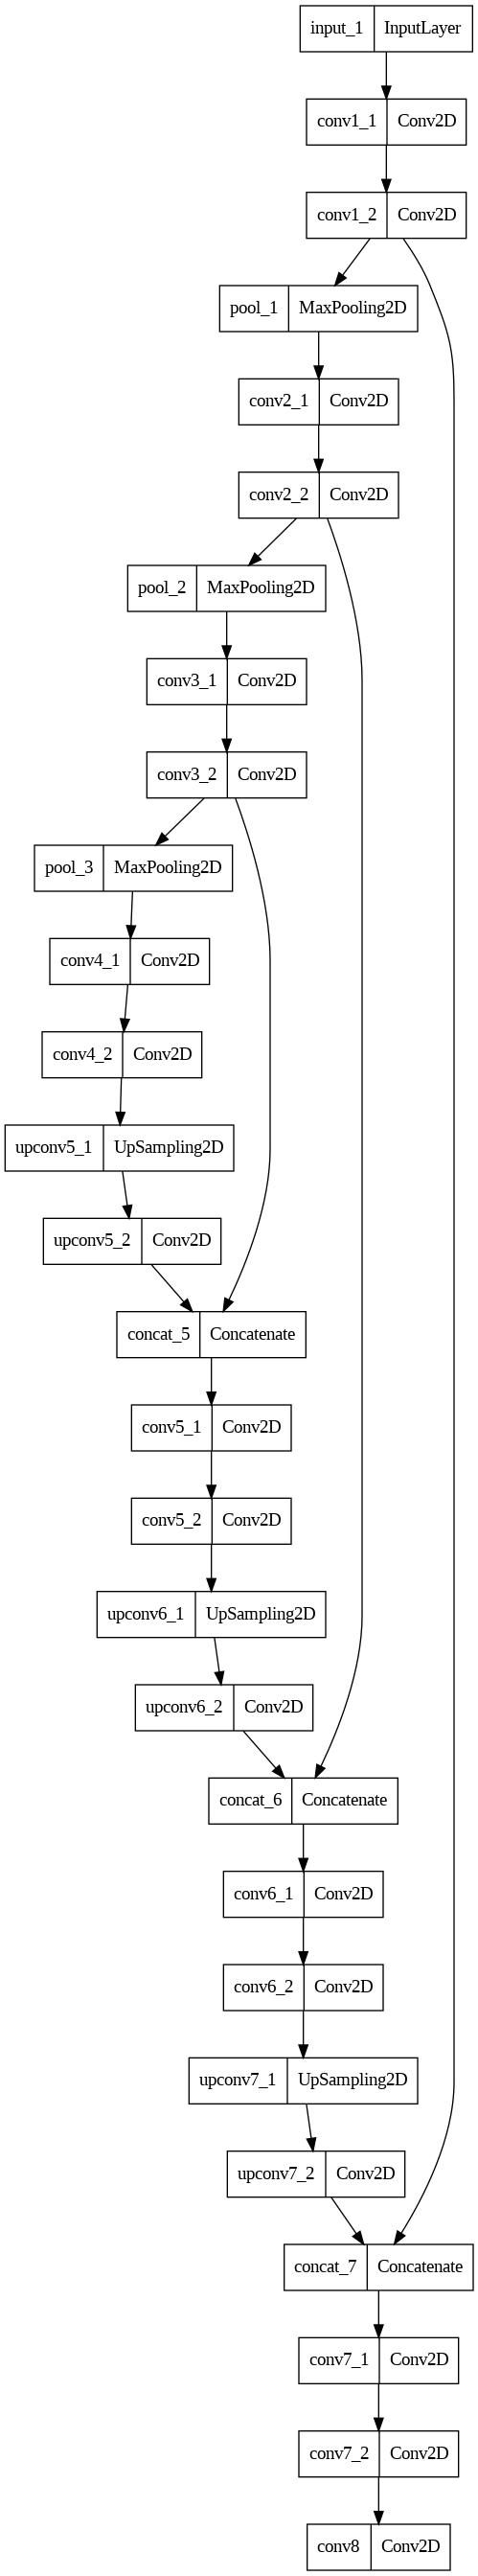

## 2.1. Создайте модель со следующей архитектурой:

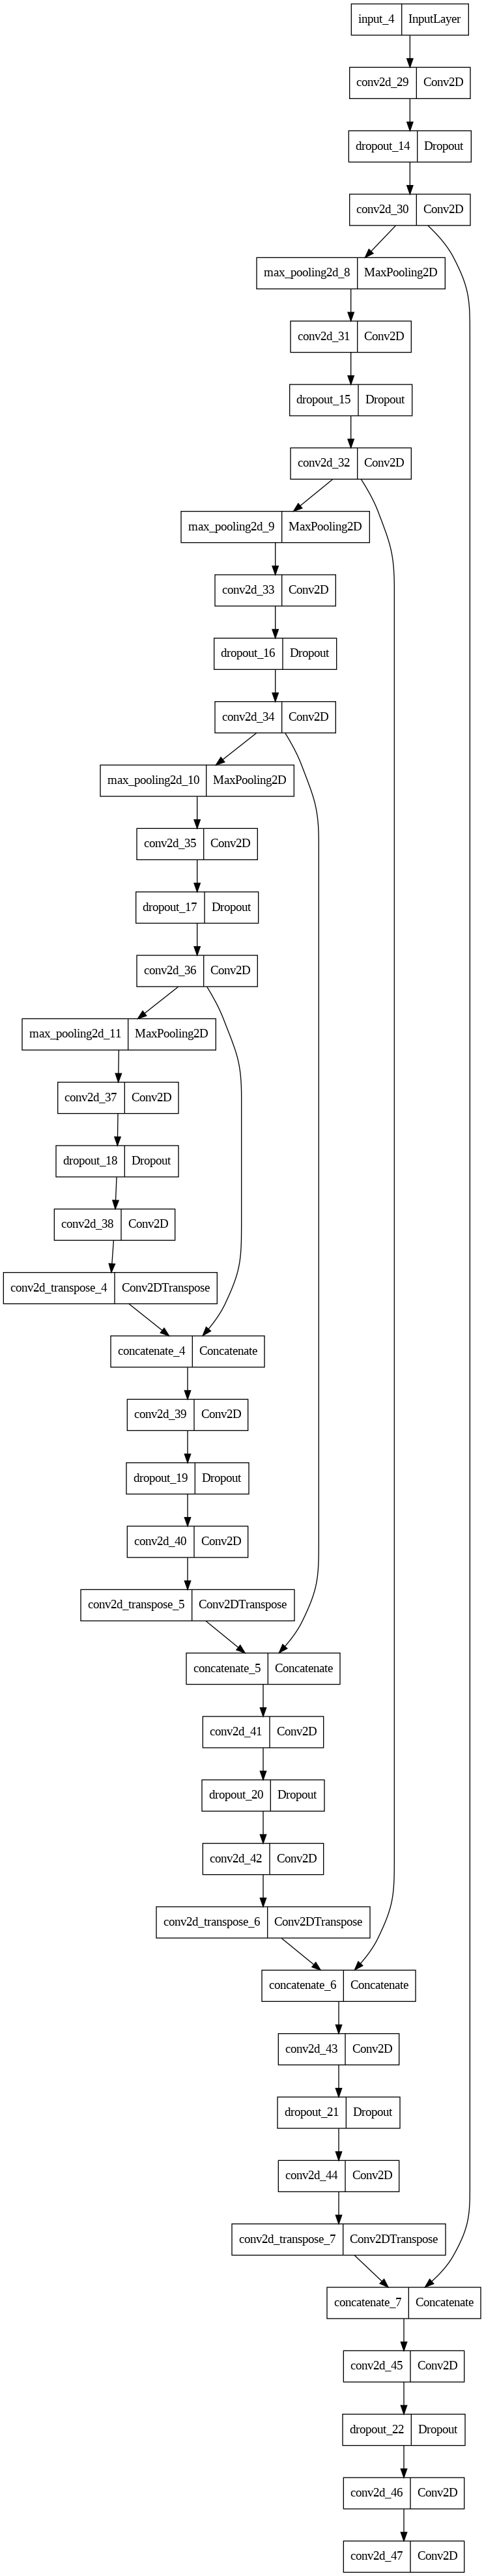

In [ ]:
from keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, Cropping2D, Softmax, Conv2DTranspose
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

In [50]:
def mini_u_net(image_shape, num_of_classes):

    input_image = Input(image_shape)

    # Encoder

    conv1_1 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_1')(input_image)
    dropout1_1 = Dropout(rate=0.2)(conv1_1)
    conv1_2 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_2')(dropout1_1)

    pool_1 = MaxPooling2D(pool_size=(2,2), name = 'pool_1')(conv1_2)

    conv2_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_1')(pool_1)
    dropout2_1 = Dropout(rate=0.2)(conv2_1)
    conv2_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_2')(dropout2_1)

    pool_2 = MaxPooling2D(pool_size=(2,2), name = 'pool_2')(conv2_2)

    conv3_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_1')(pool_2)
    dropout3_1 = Dropout(rate=0.2)(conv3_1)
    conv3_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_2')(dropout3_1)

    pool_3 = MaxPooling2D(pool_size=(2,2), name = 'pool_3')(conv3_2)

    conv4_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_1')(pool_3)
    dropout4_1 = Dropout(rate=0.2)(conv4_1)
    conv4_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_2')(dropout4_1)


    pool_4 = MaxPooling2D(pool_size=(2,2), name = 'pool_4')(conv4_2)


    conv5_1 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_1')(pool_4)
    dropout5_1 = Dropout(rate=0.2)(conv5_1)
    conv5_2 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_2')(dropout5_1)

    # Decoder

    upconv5_1 = Conv2DTranspose(filters = 128, kernel_size = (2, 2), strides=(2, 2), activation = 'linear', padding = 'same', name = 'upconv5_1')(conv5_2)

    concat_5 = concatenate([upconv5_1, conv4_2], axis = 3, name = 'concat_5') # Split Connections


    conv6_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_1')(concat_5)
    dropout6_1 = Dropout(rate=0.2)(conv6_1)
    conv6_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_2')(dropout6_1)
    upconv6_1 = Conv2DTranspose(filters = 64, kernel_size = (2, 2), strides=(2, 2), activation = 'linear', padding = 'same', name = 'upconv6_1')(conv6_2)

    concat_6 = concatenate([upconv6_1, conv3_2], axis = 3, name = 'concat_6') # Split Connections

    conv7_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_1')(concat_6)
    dropout7_1 = Dropout(rate=0.2)(conv7_1)
    conv7_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_2')(dropout7_1)
    upconv7_1 = Conv2DTranspose(filters = 32, strides=(2, 2), kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv7_1')(conv7_2)

    concat_7 = concatenate([upconv7_1, conv2_2], axis = 3, name = 'concat_7') # Split Connections

    conv8_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv8_1')(concat_7)
    dropout8_1 = Dropout(rate=0.2)(conv8_1)
    conv8_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv8_2')(dropout8_1)
    upconv8_1 = Conv2DTranspose(filters = 16, strides=(2, 2), kernel_size = (2, 2), activation = 'linear', padding = 'same', name = 'upconv8_1')(conv8_2)

    concat_8 = concatenate([upconv8_1, conv1_2], axis = 3, name = 'concat_8') # Split Connections


    conv9_1 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv9_1')(concat_8)
    dropout9_1 = Dropout(rate=0.2)(conv9_1)
    conv9_2 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv9_2')(dropout9_1)

    conv10 = Conv2D(filters = num_of_classes, kernel_size = (1, 1), activation = 'softmax', name = 'conv10')(conv9_2)

    model = Model(inputs = input_image, outputs = conv10, name = 'model')

    return model

In [51]:
my_unet_model = mini_u_net(image_shape = [256, 256, 3], num_of_classes = 6)

In [52]:
my_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 256, 256, 16  0           ['conv1_1[0][0]']                
                                )                                                             

In [ ]:
my_unet_model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_2'},
   'name': 'input_2',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv1_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv1_1',
   'inbound_nodes': [[['input_2', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config'

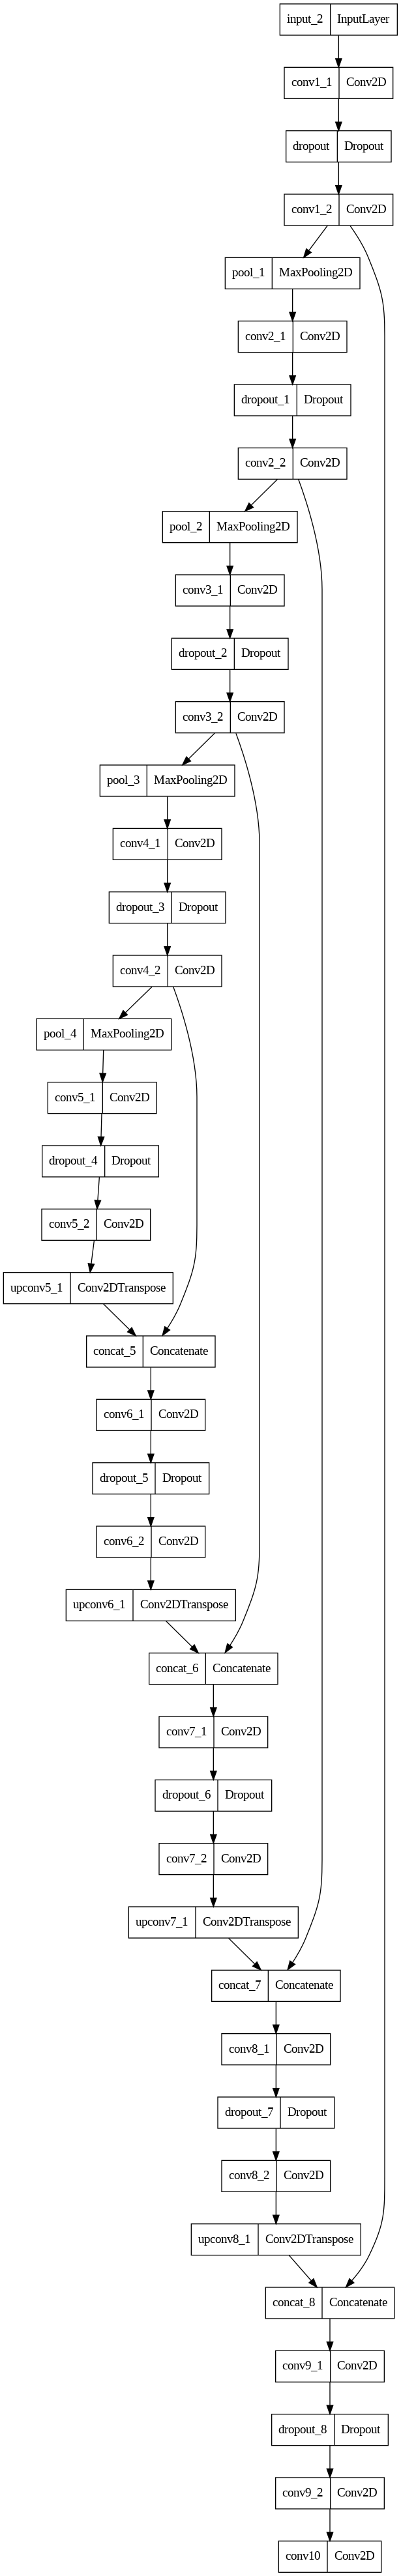

In [ ]:
plot_model(my_unet_model,
           to_file='my_model.png',
           show_shapes=False,
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=96
)

## 2.2. Обучите созданную модель для решения задачи семантической сегментации. В качестве функции потерь используйте ту, которая лучше всего показала себя в задании №1

In [54]:
my_unet_model = mini_u_net(image_shape = [256, 256, 3], num_of_classes = 5)
my_unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
history3=my_unet_model.fit(
          train_img_gen,
          steps_per_epoch=train_steps_count,
          epochs=10,
          verbose=1,
          validation_data=None)

Epoch 1/10
7/7 [==============================] - 111s 15s/step - loss: 1.5071 - accuracy: 0.4463 - iou_score: 0.0911 - f1-score: 0.1567
Epoch 2/10
7/7 [==============================] - 122s 18s/step - loss: 1.1202 - accuracy: 0.5720 - iou_score: 0.1239 - f1-score: 0.1946
Epoch 3/10
7/7 [==============================] - 107s 15s/step - loss: 1.1110 - accuracy: 0.5495 - iou_score: 0.1240 - f1-score: 0.1998
Epoch 4/10
4/7 [================>.............] - ETA: 48s - loss: 1.0839 - accuracy: 0.5717 - iou_score: 0.1318 - f1-score: 0.2046 

KeyboardInterrupt: 

### 2.2.1. Загрузите три снимка, а также маски, соответствующие этим снимкам

In [ ]:
test_img_dir = '/content/drive/MyDrive/dataset/Semantic segmentation dataset/Tile 8/images'
test_mask_dir = '/content/drive/MyDrive/dataset/Semantic segmentation dataset/Tile 8/masks'
test_img_list = sorted(os.listdir(test_img_dir))[0:3]
test_mask_list = sorted(os.listdir(test_mask_dir))[0:3]

test_num_images = len(test_img_list)

### 2.2.2. Используя обученную модель, обработайте снимки по технологии, рассмотренной на практическом занятии (делим снимок на части, затем каждую часть обрабатываем нейросетью, а после соединяем все части для получения полноразмерной маски исходного снимка)

In [ ]:
# Ваш код

### 2.2.3. Загрузите наиболее удачную модель из предыдущего задания (Задания №1). Сравните её точность с моделью, обученной в этом задании:

In [ ]:
# Ваш код

### 2.2.4. Отобразите предсказанную маску для каждого из трех снимков, загруженных ранее, в следующем формате: (исходный снимок, эталонная маска, предсказанная маска по модели, обученной в этом задании, предсказанная маска по модели, обученной в первом задании.

In [ ]:
# Ваш код


# Задание №3. Реализация готового решения для полноразмерной семантической сегментации спутникового снимка

## Реализуйте готовый алгоритм, который принимает на вход полноразмерное изображение и маску (опционально). После чего на его основе формирует полноразмерную маску, предсказанную наиболее удачной моделью нейронной сети, обученной ранее в Задании №1 или Задании №2.

In [ ]:
# Ваш код

- Сравните получившийся результат с эталонной маской

In [ ]:
# Ваш код

- Реализуйте графический интерфейс с помощью Gradio. На вход подается только исходный растр - на выходе отображается сгенерированная маска. Также маска автоматически должна сохраняться в корневом каталоге.

In [ ]:
# Ваш код